# Bone suppression(pix2pix)

参考：[Pix2Pix  |  TensorFlow Core](https://www.tensorflow.org/tutorials/generative/pix2pix#training)

## 前準備
### 主要パッケージのインポート

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
from logging import basicConfig, getLogger, INFO
basicConfig(level=INFO, format='%(asctime)s %(levelname)s :%(message)s')
logger = getLogger(__name__)

### データディレクトリの指定

In [2]:
DATA_ROOT = pathlib.Path('Data/Images/chest_xray')
INPUT_IMAGE_DIR = 'bone_enhancement'
TRUTH_IMAGE_DIR = 'bone_suppression'
CLASS_LABELS = ('lung')
IMAGE_EXT = '.png'

### 画像ファイルを基にpd.DataFrameを作成する

In [3]:
def create_dataset_df(data_root, input_dir, truth_dir, image_ext):
    dfs = []
    root = pathlib.Path(data_root)
    image_filenames = (root / pathlib.Path(input_dir)).glob('*' + image_ext)
    df = pd.DataFrame(image_filenames, columns=['input_path'])
    df['truth_path'] = df['input_path'].map(
        lambda p: root / pathlib.Path(truth_dir) / p.name)
    return df


df_dataset = create_dataset_df(DATA_ROOT, INPUT_IMAGE_DIR, TRUTH_IMAGE_DIR,
                               IMAGE_EXT)
display(df_dataset.head())

,input_path,truth_path
0,Data\Images\chest_xray\bone_enhancement\000.png,Data\Images\chest_xray\bone_suppression\000.png
1,Data\Images\chest_xray\bone_enhancement\001.png,Data\Images\chest_xray\bone_suppression\001.png
2,Data\Images\chest_xray\bone_enhancement\002.png,Data\Images\chest_xray\bone_suppression\002.png
3,Data\Images\chest_xray\bone_enhancement\003.png,Data\Images\chest_xray\bone_suppression\003.png
4,Data\Images\chest_xray\bone_enhancement\004.png,Data\Images\chest_xray\bone_suppression\004.png


### 画像を表示

<Figure size 720x360 with 0 Axes>

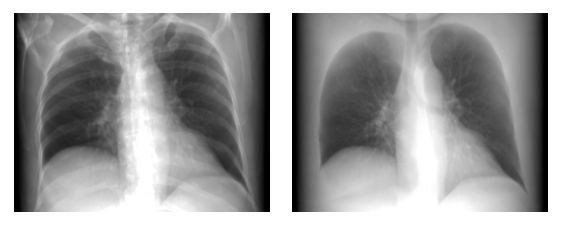

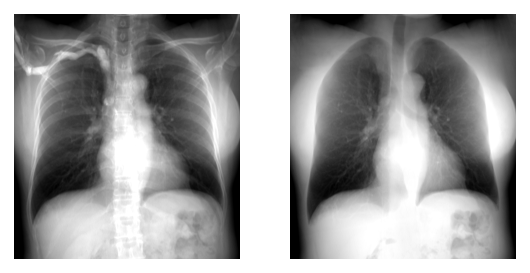

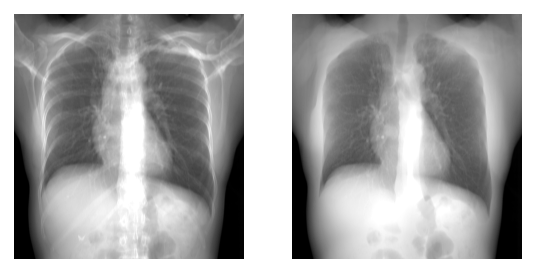

In [4]:
N_SAMPLES = 3
plt.figure(figsize=(10, 5))
for i, sample in enumerate(df_dataset.sample(n=N_SAMPLES).itertuples()):
    image = Image.open(sample.input_path)
    truth = Image.open(sample.truth_path)
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(truth, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## モデル作成

### Generator model
構造はhttps://www.tensorflow.org/tutorials/generative/pix2pix のgeneratorを使う。

In [5]:
import tensorflow as tf


def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters,
                               size,
                               strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters,
                                        size,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

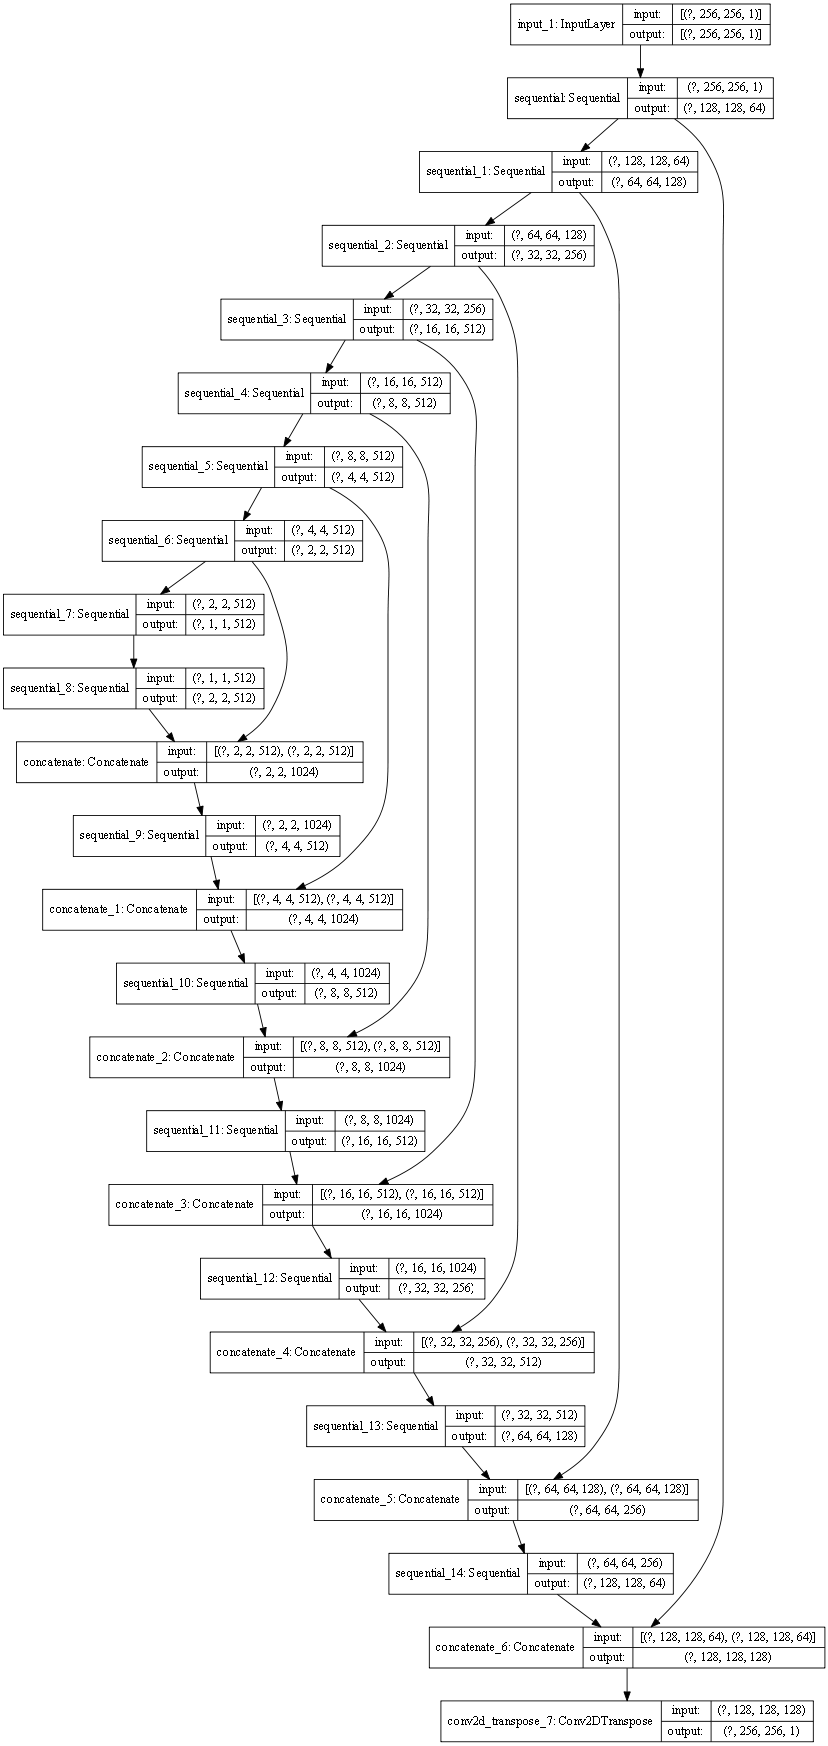

In [6]:
INPUT_SHAPE = [256, 256, 1]
OUTPUT_CHANNELS = 1
OUTPUT_SHAPE = INPUT_SHAPE[:2] + [OUTPUT_CHANNELS]


def Generator():
    inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS,
        4,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='linear')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

### Generator loss

In [7]:
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output),
                           disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

### Discriminator model

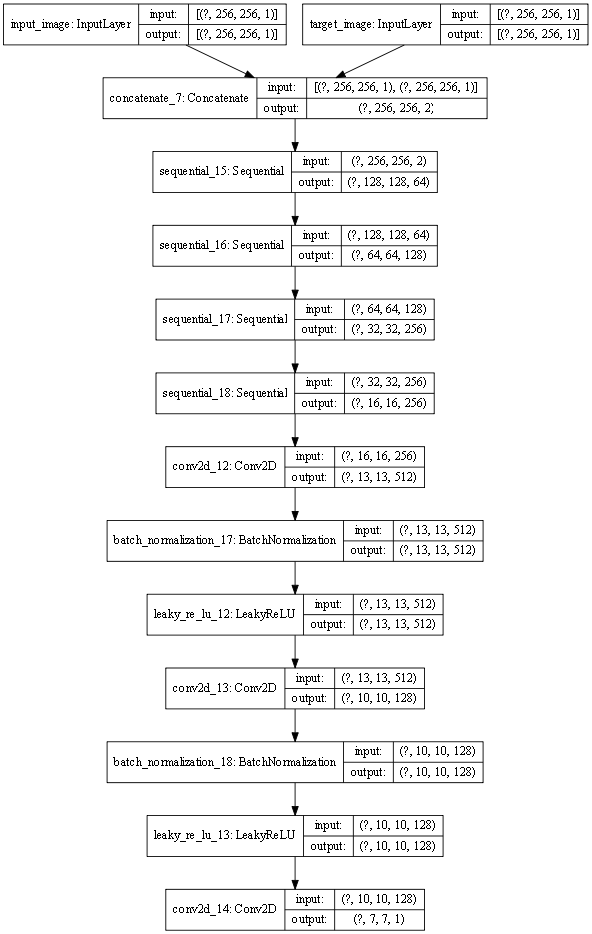

In [8]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=OUTPUT_SHAPE, name='input_image')
    tar = tf.keras.layers.Input(shape=OUTPUT_SHAPE, name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)
    down4 = downsample(256, 4)(down3)  # (bs, 32, 32, 256)

#     zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    zero_pad1 = down4
    conv = tf.keras.layers.Conv2D(512,
                                  4,
                                  strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(
                                      zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    leaky_relu = tf.keras.layers.Conv2D(128,4,strides=1)(leaky_relu)
    leaky_relu = tf.keras.layers.BatchNormalization()(leaky_relu)
    leaky_relu = tf.keras.layers.LeakyReLU()(leaky_relu)

#     zero_pad2 = tf.keras.layers.ZeroPadding2D()(
#         leaky_relu)  # (bs, 33, 33, 512)
    zero_pad2 = leaky_relu

    last = tf.keras.layers.Conv2D(1,
                                  4,
                                  strides=1,
                                  kernel_initializer=initializer)(
                                      zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

### Discriminator loss

In [9]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output),
                                 disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

### Optimizer

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = pathlib.Path('pi2pix_training_checkpoints')
checkpoint_prefix = checkpoint_dir / 'ckpt'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 学習
### ホールドアウト

In [11]:
from sklearn.model_selection import KFold
N_SPLITS = 5
SEED = 0
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
train_index, test_index = next(kfold.split(df_dataset['input_path']))

df_train = df_dataset.iloc[train_index]
df_test = df_dataset.iloc[test_index]

In [12]:
import tqdm
IMG_SHAPE = INPUT_SHAPE


def load_img(filepath):
    return np.atleast_3d(
        tf.keras.preprocessing.image.load_img(filepath,
                                              color_mode='grayscale',
                                              target_size=IMG_SHAPE))


def load_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((
        np.stack([
            load_img(filepath) for filepath in tqdm.tqdm(df['input_path'])
        ]),
        np.stack([
            load_img(filepath) for filepath in tqdm.tqdm(df['truth_path'])
        ]),
    ))
    return dataset

train_dataset = load_dataset(df_train)
test_dataset = load_dataset(df_test)
print(train_dataset.element_spec, test_dataset.element_spec)

100%|██████████| 57/57 [00:00<00:00, 390.82it/s]

(TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None)) (TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))


### Data augmentation

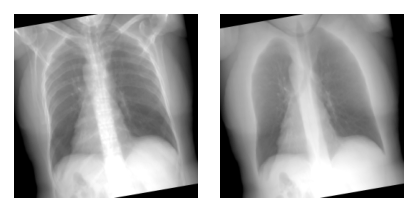

In [13]:
import tensorflow_addons as tfa


def convert(image, truth):
    image = tf.image.convert_image_dtype(image, tf.float32)
    truth = tf.image.convert_image_dtype(truth, tf.float32)
    return image, truth


MAX_ANGLE_DEG = 10
MAX_ANGLE_RAD = np.deg2rad(MAX_ANGLE_DEG)
FLIP_RATE = .5
BRIGHTNESS_RANGE = .2


def augment(image, truth):
    image, truth = convert(image, truth)
    # rotate
    angle = tf.random.uniform((), minval=-MAX_ANGLE_RAD, maxval=MAX_ANGLE_RAD)
    image = tfa.image.rotate(image, angle, interpolation='BILINEAR')
    truth = tfa.image.rotate(truth, angle, interpolation='BILINEAR')

    # flip
    if tf.random.uniform(()) < FLIP_RATE:
        image = tf.image.flip_left_right(image)
        truth = tf.image.flip_left_right(truth)

    # brightness
    brightness_offset = tf.random.uniform((),
                                          minval=-BRIGHTNESS_RANGE,
                                          maxval=BRIGHTNESS_RANGE)
    image = image + brightness_offset
    truth = truth + brightness_offset

    return image, truth


for d in train_dataset.map(augment):
    plt.figure(figsize=(3, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(d[0][..., 0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(d[1][..., 0], cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

### fit

In [14]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output],
                                              training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients, discriminator.trainable_variables))
    
#     with summary_writer.as_default():
#         tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
#         tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
#         tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
#         tf.summary.scalar('disc_loss', disc_loss, step=epoch)

    return (gen_total_loss, gen_gan_loss, gen_l1_loss), disc_loss


2020-06-16 09:08:20,970 INFO :start of training
  0%|          | 0/228 [00:00<?, ?batch/s]2020-06-16 09:08:20,983 INFO :generate_images


<Figure size 1080x1080 with 0 Axes>

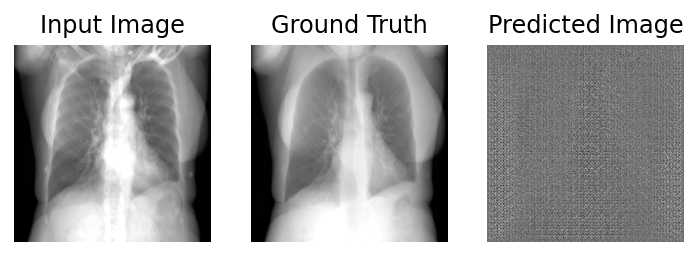

64/512 [G_L=2.9,G_L_gan=0.76,G_L_l1=0.022,D_L=1.4]:   0%|          | 0/228 [00:00<00:17, 13.30batch/s, G_L=3.63, G_L_gan=1.15, G_L_l1=0.0248, D_L=1.31]2020-06-16 09:16:23,632 INFO :generate_images


<Figure size 1080x1080 with 0 Axes>

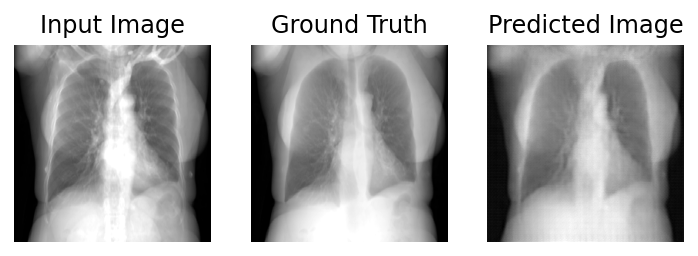

128/512 [G_L=2.9,G_L_gan=1,G_L_l1=0.019,D_L=1.2]:   0%|          | 0/228 [00:00<00:17, 13.38batch/s, G_L=3.14, G_L_gan=1.21, G_L_l1=0.0193, D_L=0.473]2020-06-16 09:24:42,808 INFO :generate_images


<Figure size 1080x1080 with 0 Axes>

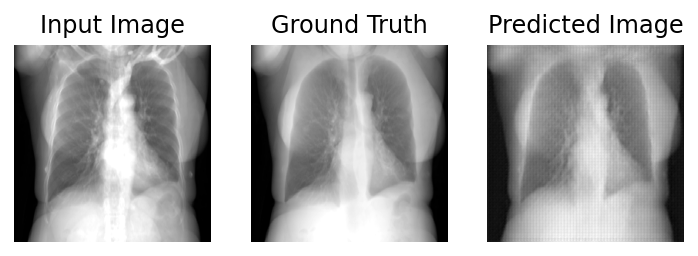

320/512 [G_L=2.7,G_L_gan=1,G_L_l1=0.017,D_L=1.4]:   0%|          | 0/228 [00:00<00:20, 10.92batch/s, G_L=2.41, G_L_gan=0.84, G_L_l1=0.0157, D_L=1.48]2020-06-16 09:52:05,250 INFO :generate_images


<Figure size 1080x1080 with 0 Axes>

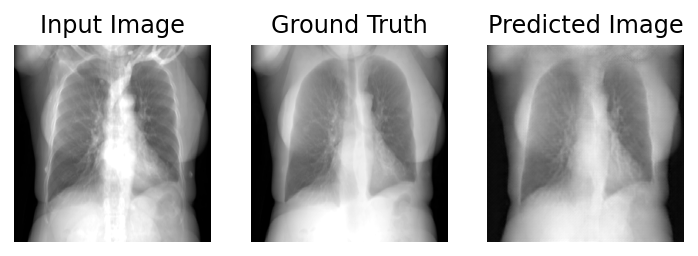

358/512 [G_L=3.1,G_L_gan=1.5,G_L_l1=0.016,D_L=0.97]: : 232batch [00:09, 10.61batch/s, G_L=2.31, G_L_gan=0.742, G_L_l1=0.0157, D_L=1.14]

In [15]:
import time

EPOCHS = 512
BATCH_SIZE = 8
DISPLAY_FREQ = EPOCHS // 8

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_dataset.shuffle(BATCH_SIZE * 16).map(
    augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


def generate_images(model, test_input, tar):
    prediction = model(test_input[np.newaxis], training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input, tar, prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    plt.figure(figsize=(6, 3))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i][..., 0], cmap='gray')
        plt.axis('off')
    plt.show()


def fit(train_ds, epochs, test_ds):
    pbar_total = len(train_index)
    all_logs = []
    with tqdm.tqdm(total=pbar_total, unit='batch') as pbar:
        for epoch in range(epochs):
            pbar.reset(total=pbar_total)
            logs = []

            if epoch % DISPLAY_FREQ == 0:
                for example_input, example_target in test_ds.map(convert).take(
                        1):
                    logger.info('generate_images')
                    generate_images(generator, example_input, example_target)

            for n, (input_image, target) in train_ds.enumerate():
                gen_loss, disc_loss = train_step(input_image, target, epoch)
                pbar.update(BATCH_SIZE)
                cur_logs = {
                    'G_L': gen_loss[0].numpy(),
                    'G_L_gan': gen_loss[1].numpy(),
                    'G_L_l1': gen_loss[2].numpy(),
                    'D_L': disc_loss.numpy()
                }
                pbar.set_postfix(cur_logs)
                logs.append(cur_logs)

            summary = pd.DataFrame(logs).mean().to_dict()
            pbar.set_description('{}/{} [{}]'.format(
                epoch + 1, epochs, ','.join(
                    ['{}={:.02g}'.format(k, v) for k, v in summary.items()])))
            all_logs.append(summary)

        return all_logs

# saving (checkpoint) the model every 20 epochs
#         if (epoch + 1) % 20 == 0:
#             checkpoint.save(file_prefix=checkpoint_prefix)

#         print('Time taken for epoch {} is {} sec\n'.format(
#             epoch + 1,
#             time.time() - start))
#     checkpoint.save(file_prefix=checkpoint_prefix)

logger.info('start of training')
logs = fit(train_ds, EPOCHS, test_dataset)
logger.info('end of training')

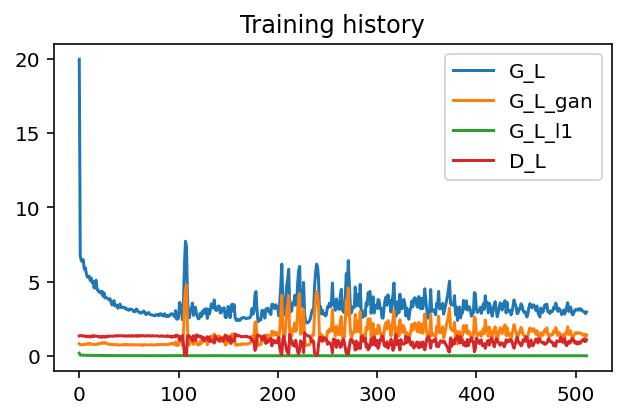

In [16]:
pd.DataFrame(logs).plot(title='Training history', figsize=(5, 3))
plt.show()

## 評価
準備中

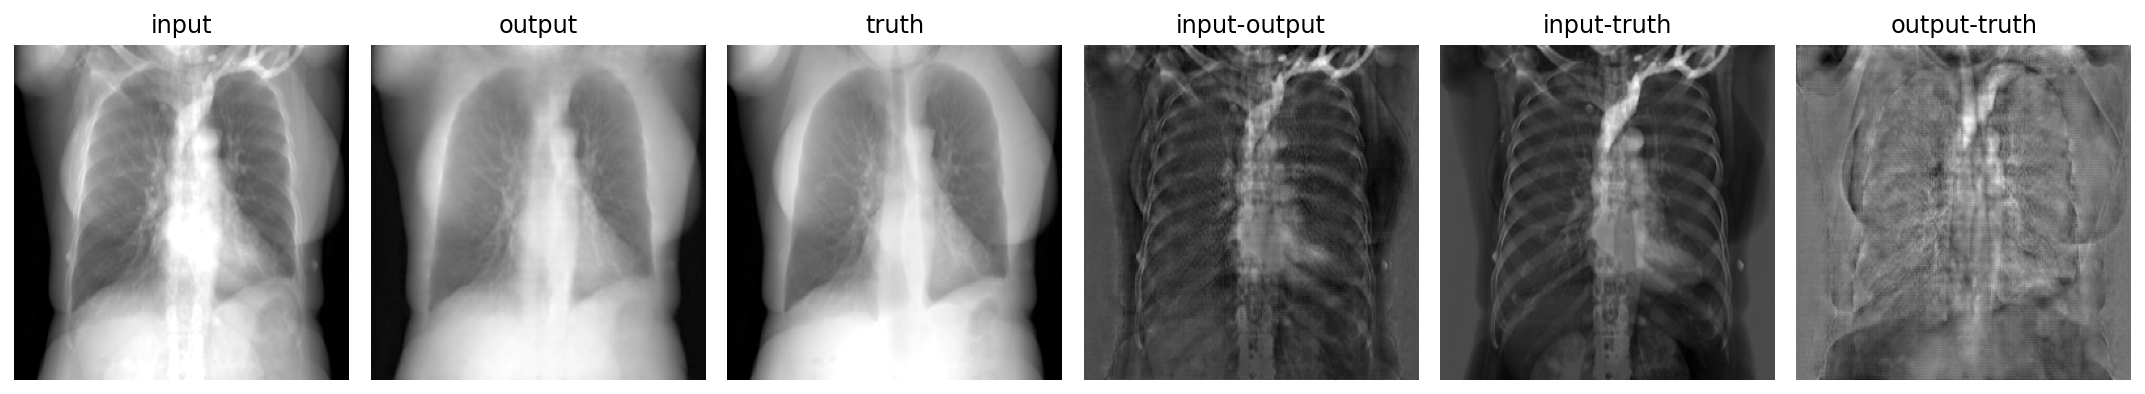

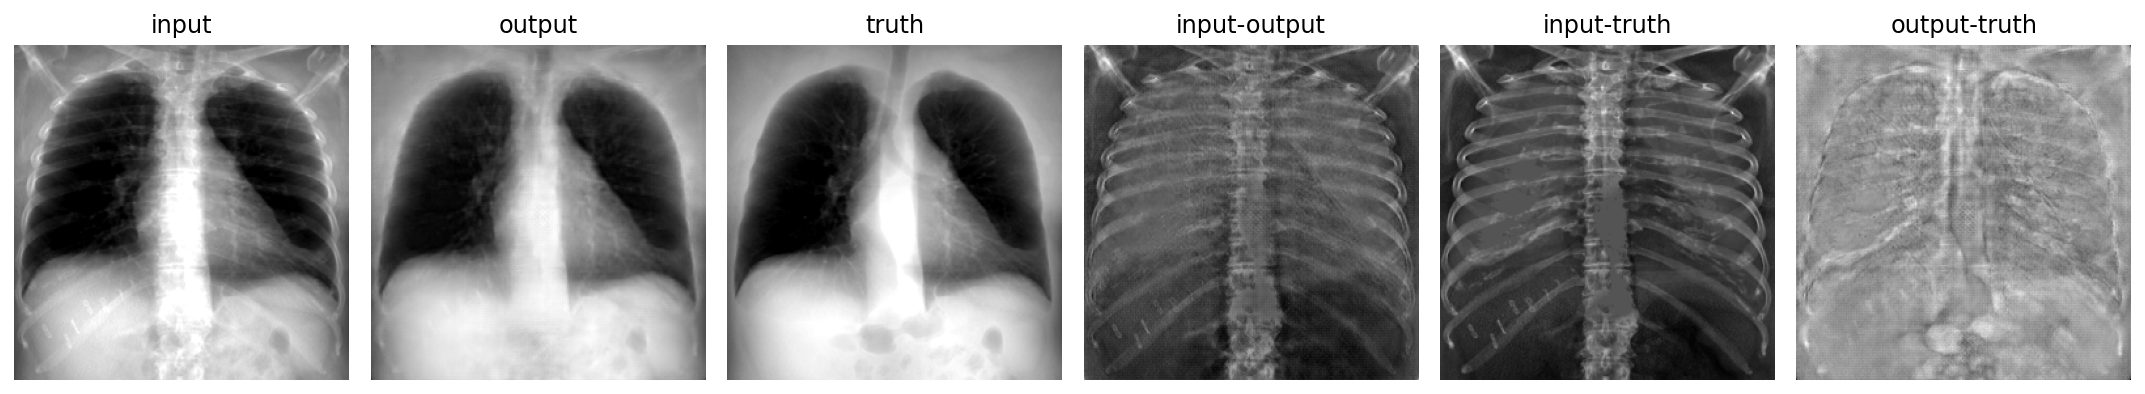

In [17]:
import math
from sklearn import metrics


def show_images_in_a_row(images, titles, figsize=(15, 5)):
    assert len(images) == len(titles), 'Invalid size of arguments'
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


scores = []
for i, batch in enumerate(test_dataset.map(convert).batch(1)):
    pred = generator(batch[0])
    
    pred = pred[0,...,0]
    image = batch[0][0,...,0]
    truth = batch[1][0,...,0]
    if i < 2:
        show_images_in_a_row(*zip((image, 'input'), (pred, 'output'), (
            truth, 'truth'), (image - pred, 'input-output'), (
                image - truth, 'input-truth'), (pred - truth, 'output-truth')))
    else:
        break

In [18]:
generator.save('pix2pix_generator.h5')